In [2]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
from cluster_toolkit import deltasigma
from cluster_toolkit import concentration as conc
from cluster_toolkit import density
import pyccl as ccl

In [16]:
# for lens, source setup
mass = 5e14   # [Msun/h]

z_L = 0.1
z_S = 0.4

a_S = 1./(1.+z_S)
a_L = 1./(1.+z_L)

R_max = 10. # Mpc/h
log_R_max = np.log10(R_max)

# for ccl set up

par_cosmology = {
    'Omega_m': 0.3166,
    'A_s': 2.101e-9,
    'n_s': 0.9649,
    'Omega_b': 0.0494,
    'h': 0.6727,
    'w0': -1.0,
    'wa': 0.0,
    'm_nu': 0.06
} # 

par_cosmology['Omega_c'] = par_cosmology['Omega_m'] - par_cosmology['Omega_b']

cosmo = ccl.Cosmology(Omega_c=par_cosmology['Omega_c'], 
                     Omega_b=par_cosmology['Omega_b'], 
                     h=par_cosmology['h'], 
                     A_s=par_cosmology['A_s'],
                     n_s=par_cosmology['n_s'], 
                     transfer_function='boltzmann_camb',
                     matter_power_spectrum='halofit')


Omega_m = par_cosmology['Omega_m']
Omega_b = par_cosmology['Omega_b'] 
n_s = par_cosmology['n_s'] 
h = par_cosmology['h'] 

# k and P are coming from somewhere, e.g. CAMB or CLASS
# k are wavenumbers in h/Mpc and P is the linear power spectrum in (Mpc/h)^3
k_max = 30 # unit [1/Mpc]
k = np.logspace(-5, np.log10(k_max), num=1000)
Plin = ccl.linear_matter_power(cosmo=cosmo, k=k, a=a_L) # unit [1/Mpc^3]

# convert units to h/Mpc and (Mpc/h)^3 to use in the toolkit.
k /= h
Plin *= h**3

In [17]:
concentration = conc.concentration_at_M(Mass=mass, k=k, P=Plin, 
                                        n_s=n_s, Omega_b=Omega_b, Omega_m=Omega_m, h=h, 
                                        Mass_type='mean') # Mass_type = 'mean' or 'crit'

print(f'concentration for M={mass:.2e} Msun/h halo at z={z_L}:', concentration)

concentration for M=5.00e+14 Msun/h halo at z=0.1: 6.439707250164596


In [18]:
radii = np.logspace(-2, 3, 100) # Mpc/h comoving
rho_nfw = density.rho_nfw_at_r(r=radii, M=mass, c=concentration, Omega_m=Omega_m)

Text(0.5, 0, 'r  [Mpc/h]')

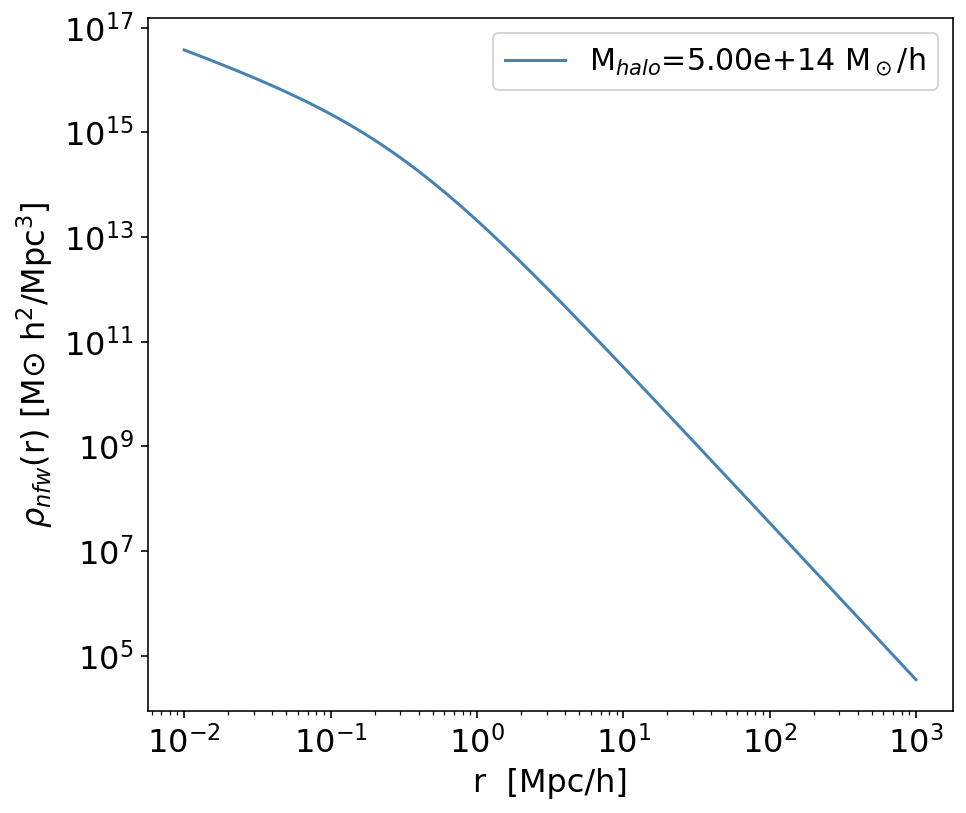

In [19]:
fig, ax = plt.subplots(1,1, figsize=(6.5,6.5))
fig.subplots_adjust(left=0.12, right=0.98, bottom=0.11, top=0.85)
plt.rc('font',size=16)

label = 'M$_{halo}$='+f'{mass:.2e}'+' M$_\odot$/h'
ax.plot(radii, rho_nfw, linestyle='-', label=label, color='steelblue')

ax.set_yscale('log')
ax.set_xscale('log')

ax.legend(loc='best',prop={'size':15})
ax.set_ylabel('$\\rho$$_{nfw}$(r) [M$\odot$ h$^2$/Mpc$^3$]')
ax.set_xlabel('r  [Mpc/h]')

In [20]:
R_perp = np.logspace(-2, log_R_max, 100) # Mpc/h comoving distance on the sky
Sigma_nfw = deltasigma.Sigma_nfw_at_R(R_perp, mass, concentration, Omega_m)
DeltaSigma = deltasigma.DeltaSigma_at_R(R=R_perp, Rs=R_perp, Sigma=Sigma_nfw, mass=mass, concentration=concentration, Omega_m=Omega_m)

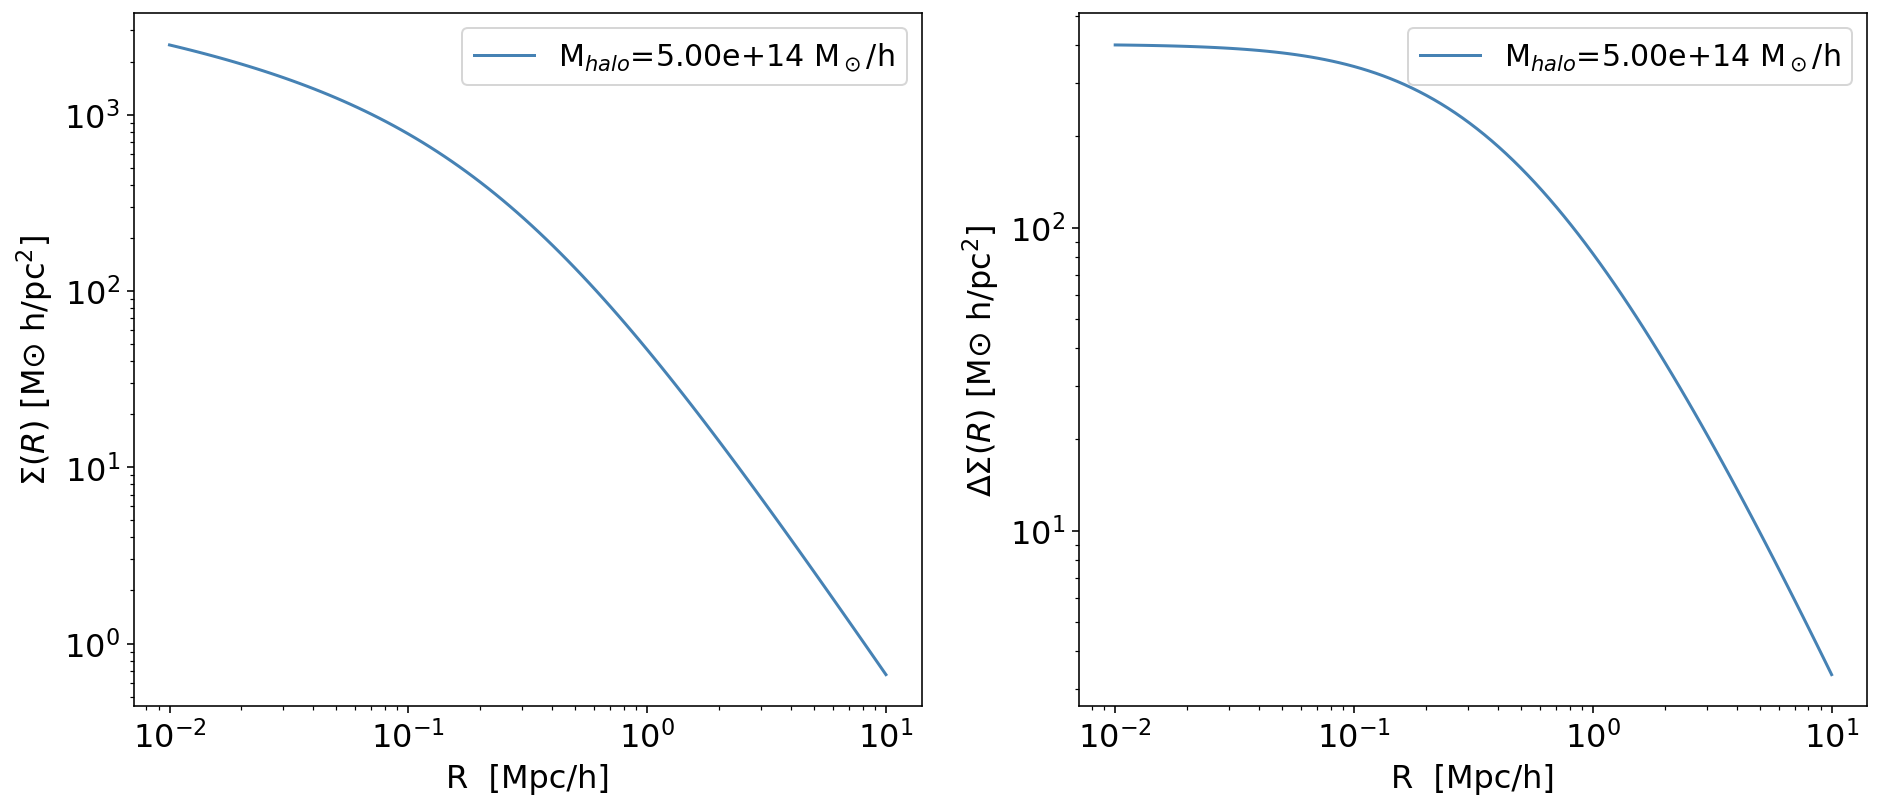

In [21]:
fig, ax = plt.subplots(1,2, figsize=(14,6.5))
fig.subplots_adjust(left=0.12, right=0.98, bottom=0.11, top=0.85)
plt.rc('font',size=16)

label = 'M$_{halo}$='+f'{mass:.2e}'+' M$_\odot$/h'

ax[0].plot(R_perp, Sigma_nfw, linestyle='-', label=label, color='steelblue')
ax[0].set_ylabel('$\Sigma(R)$ [M$\odot$ h/pc$^2$]')
ax[0].set_xlabel('R  [Mpc/h]')

ax[1].plot(R_perp, DeltaSigma, linestyle='-', label=label, color='steelblue')
ax[1].set_ylabel('$\Delta\Sigma(R)$ [M$\odot$ h/pc$^2$]')
ax[1].set_xlabel('R  [Mpc/h]')

for j in range(2):
    ax[j].set_yscale('log')
    ax[j].set_xscale('log')
    ax[j].legend(loc='best',prop={'size':15})


## critical density
## $\Sigma_{\rm crit} = \frac{c^2 D_{S}}{4 \pi G D_{SL} D_{L}}$ 

In [22]:
from pyccl.background import comoving_radial_distance

chi_L = comoving_radial_distance(cosmo, a_L)*h     # comoving distance: unit Mpc/h
chi_S = comoving_radial_distance(cosmo, a_S)*h     # comoving distance: unit Mpc/h

#D_L = chi_L/(1.+z_L) # angular diameter distance [Mpc/h]
#D_S = chi_S/(1.+z_S) 
#D_SL = (chi_S-chi_L)/(1.+z_S)

D_L = chi_L           # comoving angular diameter distance  [Mpc/h]
D_S = chi_S           # comoving angular diameter distance
D_SL = chi_S-chi_L    # comoving angular diameter distance

# turn units from Mpc/h to pc/h
D_L_pc = D_L*1e6
D_S_pc = D_S*1e6
D_SL_pc = D_SL*1e6

G_cgs = 6.67e-11    # unit: [m^3 kg^-1 s^-2]
c_cgs = 299792458   # unit: [m s^-1]

kg_to_Msun = 5.03*1e-31
m_to_pc = 3.24*1e-17

G_pcMsun = G_cgs * m_to_pc**3 * kg_to_Msun**(-1)  # unit: [pc^3 Msun^-1 s^-2]
c_pc = c_cgs * m_to_pc                            # unit: [pc s^-1]

Sigma_crit_Msun_pc2 = c_pc**2* D_S_pc / (4.*np.pi*G_pcMsun*D_L_pc*D_SL_pc)

## convergence field

## $\kappa(R) = \frac{\Sigma(R)}{\Sigma_{\rm crit}}$

In [23]:
kappa = Sigma_nfw/Sigma_crit_Msun_pc2

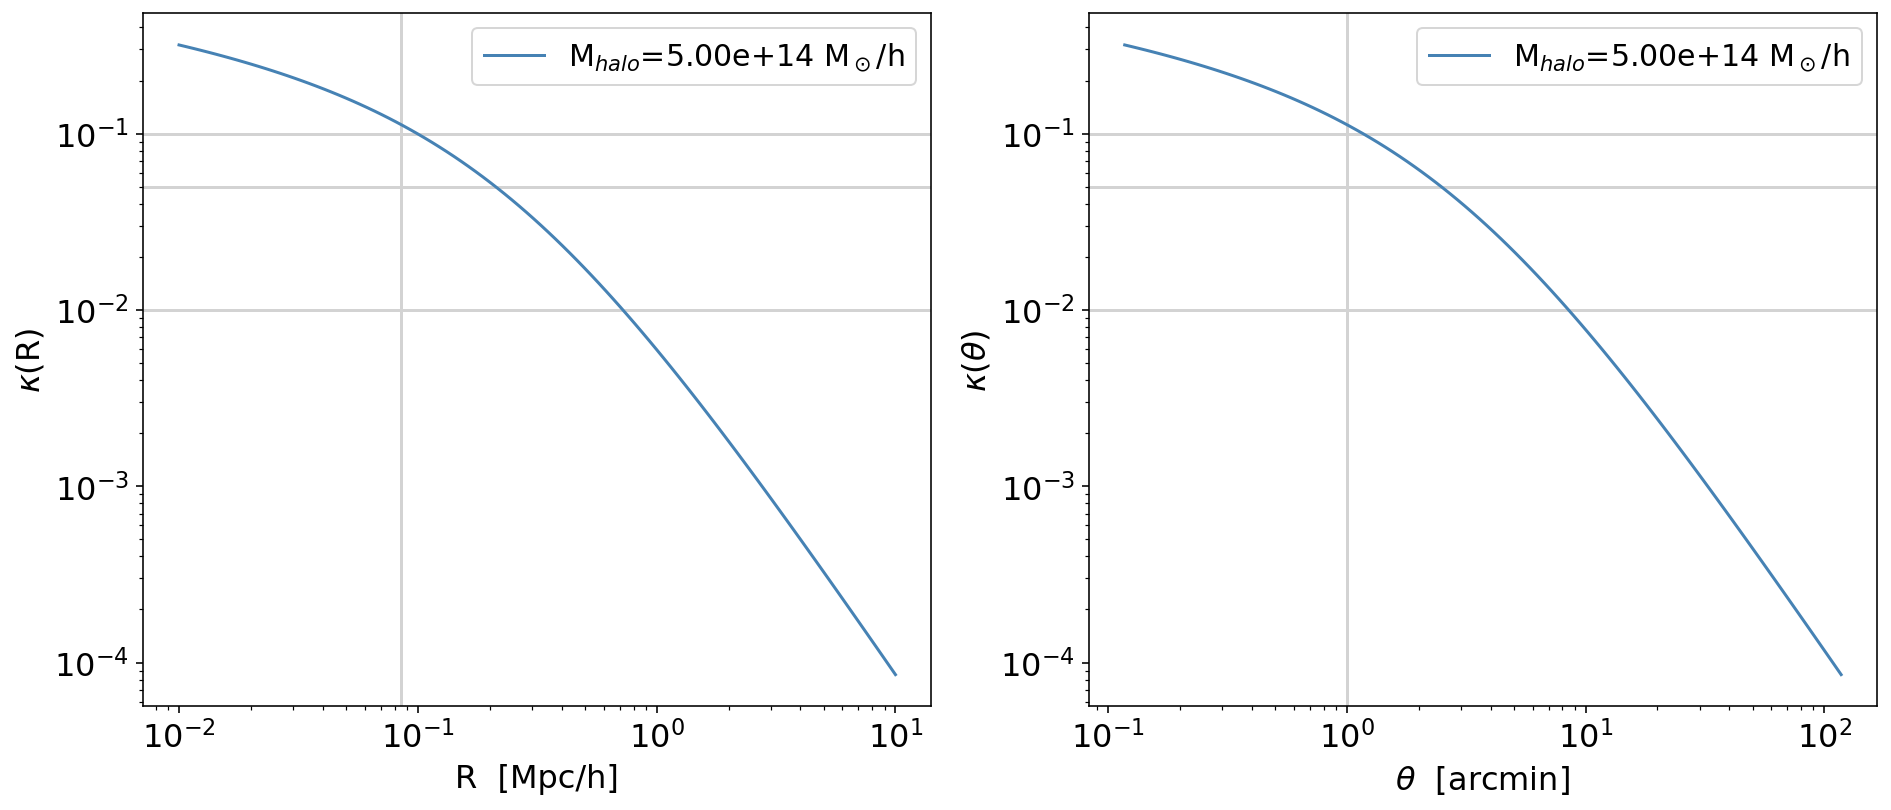

In [24]:
fig, ax = plt.subplots(1,2, figsize=(14.,6.5))
fig.subplots_adjust(left=0.12, right=0.98, bottom=0.11, top=0.85)
plt.rc('font',size=16)

label = 'M$_{halo}$='+f'{mass:.2e}'+' M$_\odot$/h'

ax[0].plot(R_perp, kappa, linestyle='-', label=label, color='steelblue')
ax[0].set_ylabel('$\kappa$(R)')
ax[0].set_xlabel('R  [Mpc/h]')

# turn to angular scale
radian_to_arcmin = 3437.75

theta_perp = R_perp/D_L * radian_to_arcmin # unit : arcmin
ax[1].plot(theta_perp, kappa, linestyle='-', label=label, color='steelblue')
ax[1].set_ylabel('$\kappa$($\\theta$)')
ax[1].set_xlabel('$\\theta$  [arcmin]')


ax[1].axvline(x=1, color='lightgray', zorder=-10)

ax[0].axvline(x=1./radian_to_arcmin*D_L, color='lightgray', zorder=-10)

for j in range(2):
    ax[j].axhline(y=0.1, color='lightgray', zorder=-10)
    ax[j].axhline(y=0.05, color='lightgray', zorder=-10)
    ax[j].axhline(y=0.01, color='lightgray', zorder=-10)


for j in range(2):
    ax[j].set_yscale('log')
    ax[j].set_xscale('log')
    ax[j].legend(loc='best',prop={'size':15})

## shear field
## $\gamma_{\rm t}(R) = \frac{\overline{\Sigma}(<R)}{\Sigma_{\rm crit}}-\frac{\Sigma(R)}{\Sigma_{\rm crit}} = \frac{\Delta\Sigma(R)}{\Sigma_{\rm crit}}$ 

In [25]:
gamma_t = DeltaSigma/Sigma_crit_Msun_pc2

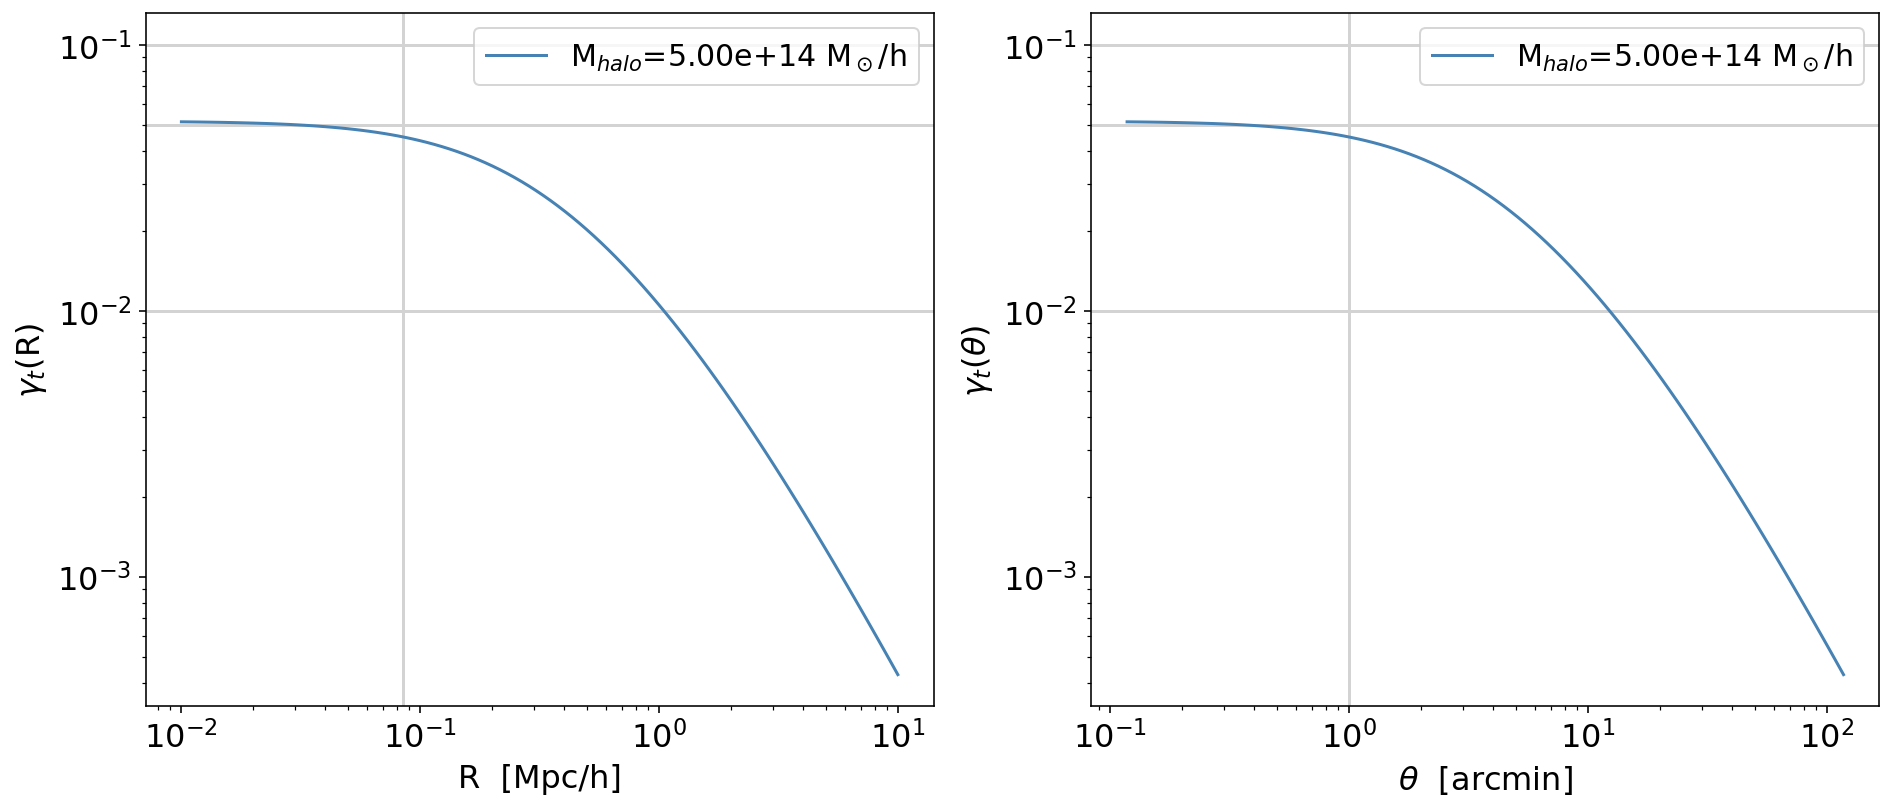

In [26]:
fig, ax = plt.subplots(1,2, figsize=(14.,6.5))
fig.subplots_adjust(left=0.12, right=0.98, bottom=0.11, top=0.85)
plt.rc('font',size=16)

label = 'M$_{halo}$='+f'{mass:.2e}'+' M$_\odot$/h'

ax[0].plot(R_perp, gamma_t, linestyle='-', label=label, color='steelblue')
ax[0].set_ylabel('$\gamma_{t}$(R)')
ax[0].set_xlabel('R  [Mpc/h]')

# turn to angular scale
radian_to_arcmin = 3437.75

theta_perp = R_perp/D_L * radian_to_arcmin # unit : arcmin
ax[1].plot(theta_perp, gamma_t, linestyle='-', label=label, color='steelblue')
ax[1].set_ylabel('$\gamma_{t}$($\\theta$)')
ax[1].set_xlabel('$\\theta$  [arcmin]')


ax[1].axvline(x=1, color='lightgray', zorder=-10)
ax[0].axvline(x=1./radian_to_arcmin*D_L, color='lightgray', zorder=-10)


for j in range(2):
    ax[j].axhline(y=0.1, color='lightgray', zorder=-10)
    ax[j].axhline(y=0.05, color='lightgray', zorder=-10)
    ax[j].axhline(y=0.01, color='lightgray', zorder=-10)


for j in range(2):
    ax[j].set_yscale('log')
    ax[j].set_xscale('log')
    ax[j].legend(loc='best',prop={'size':15})